In [1]:
import rasterio
import numpy as np
import os
from patchify import patchify
import matplotlib.pyplot as plt

In [2]:
s2_folder = "C:/surfacewatermapping/Sen1Floods11/S2Hand/"
s2_files = [f for f in os.listdir(s2_folder) if f.endswith(".tif")]

s2_images = []
for fname in s2_files:
    path = os.path.join(s2_folder, fname)
    with rasterio.open(path) as src:
        img = src.read().astype(np.float32)  # all bands
        s2_images.append(img)
        print(f"Loaded: {fname}, shape: {img.shape}, dtype: {img.dtype}")

Loaded: Bolivia_103757_S2Hand.tif, shape: (13, 512, 512), dtype: float32
Loaded: Bolivia_129334_S2Hand.tif, shape: (13, 512, 512), dtype: float32
Loaded: Bolivia_195474_S2Hand.tif, shape: (13, 512, 512), dtype: float32
Loaded: Bolivia_23014_S2Hand.tif, shape: (13, 512, 512), dtype: float32
Loaded: Bolivia_233925_S2Hand.tif, shape: (13, 512, 512), dtype: float32
Loaded: Bolivia_242570_S2Hand.tif, shape: (13, 512, 512), dtype: float32
Loaded: Bolivia_290290_S2Hand.tif, shape: (13, 512, 512), dtype: float32
Loaded: Bolivia_294583_S2Hand.tif, shape: (13, 512, 512), dtype: float32
Loaded: Bolivia_312675_S2Hand.tif, shape: (13, 512, 512), dtype: float32
Loaded: Bolivia_314919_S2Hand.tif, shape: (13, 512, 512), dtype: float32
Loaded: Bolivia_360519_S2Hand.tif, shape: (13, 512, 512), dtype: float32
Loaded: Bolivia_379434_S2Hand.tif, shape: (13, 512, 512), dtype: float32
Loaded: Bolivia_432776_S2Hand.tif, shape: (13, 512, 512), dtype: float32
Loaded: Bolivia_60373_S2Hand.tif, shape: (13, 512, 5

In [3]:
normalized_images = []

for img in s2_images:
    img = img.astype(np.float32)  # ensure float32
    norm_img = np.zeros_like(img, dtype=np.float32)

    for b in range(img.shape[0]):
        band = img[b]

        # compute 1st and 99th percentiles
        p1, p99 = np.percentile(band, [1, 99])

        # clip the band to the percentiles
        band_clipped = np.clip(band, p1, p99)

        # normalize to 0-1
        range_val = p99 - p1
        if range_val < 1e-6:
            norm_img[b] = 0.0
        else:
            norm_img[b] = (band_clipped - p1) / range_val

    normalized_images.append(norm_img)


In [4]:
for i, img in enumerate(normalized_images):
    nan_count = np.isnan(img).sum()
    inf_count = np.isinf(img).sum()
print(f"Image {i}: NaNs={nan_count}, Infs={inf_count}")

Image 445: NaNs=0, Infs=0


In [5]:
import numpy as np

patch_size = 128
stride = 128  # non-overlapping

all_patches = []

for img in normalized_images:
    # img is (C, H, W) → transpose to (H, W, C)
    img_hwc = np.transpose(img, (1, 2, 0))
    H, W, C = img_hwc.shape
    
    # loop over top-left corners of patches
    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            patch = img_hwc[i:i+patch_size, j:j+patch_size, :]
            all_patches.append(patch)

all_patches = np.array(all_patches, dtype=np.float32)
print(f"Total patches: {all_patches.shape[0]}, each of shape {all_patches.shape[1:]}")


Total patches: 7136, each of shape (128, 128, 13)


In [6]:
mask_folder = "C:/surfacewatermapping/Sen1Floods11/LabelHand/"
mask_files = [f for f in os.listdir(mask_folder) if f.endswith(".tif")]
mask_files.sort()  # ensure same order as S2 files

mask_images = []
for fname in mask_files:
    path = os.path.join(mask_folder, fname)
    with rasterio.open(path) as src:
        mask = src.read(1).astype(np.uint8) 
        mask[mask == 255] = 0 # single channel
        mask_images.append(mask)
        print(f"Loaded mask: {fname}, shape: {mask.shape}, dtype: {mask.dtype}")

Loaded mask: Bolivia_103757_LabelHand.tif, shape: (512, 512), dtype: uint8
Loaded mask: Bolivia_129334_LabelHand.tif, shape: (512, 512), dtype: uint8
Loaded mask: Bolivia_195474_LabelHand.tif, shape: (512, 512), dtype: uint8
Loaded mask: Bolivia_23014_LabelHand.tif, shape: (512, 512), dtype: uint8
Loaded mask: Bolivia_233925_LabelHand.tif, shape: (512, 512), dtype: uint8
Loaded mask: Bolivia_242570_LabelHand.tif, shape: (512, 512), dtype: uint8
Loaded mask: Bolivia_290290_LabelHand.tif, shape: (512, 512), dtype: uint8
Loaded mask: Bolivia_294583_LabelHand.tif, shape: (512, 512), dtype: uint8
Loaded mask: Bolivia_312675_LabelHand.tif, shape: (512, 512), dtype: uint8
Loaded mask: Bolivia_314919_LabelHand.tif, shape: (512, 512), dtype: uint8
Loaded mask: Bolivia_360519_LabelHand.tif, shape: (512, 512), dtype: uint8
Loaded mask: Bolivia_379434_LabelHand.tif, shape: (512, 512), dtype: uint8
Loaded mask: Bolivia_432776_LabelHand.tif, shape: (512, 512), dtype: uint8
Loaded mask: Bolivia_60373

In [7]:
import numpy as np

patch_size = 128
stride = 128  # non-overlapping

all_mask_patches = []

for mask in mask_images:
    # ensure mask is (H, W)
    H, W = mask.shape
    for i in range(0, H - patch_size + 1, stride):
        for j in range(0, W - patch_size + 1, stride):
            patch = mask[i:i+patch_size, j:j+patch_size]
            patch = np.expand_dims(patch, axis=-1)  # add channel dimension
            all_mask_patches.append(patch)

all_mask_patches = np.array(all_mask_patches, dtype=np.float32)
print(f"Total mask patches: {all_mask_patches.shape[0]}, each of shape {all_mask_patches.shape[1:]}")


Total mask patches: 7136, each of shape (128, 128, 1)


In [13]:
print(f"Image patches min: {all_patches.min()}, max: {all_patches.max()}")
print(f"Mask patches unique values: {np.unique(all_mask_patches)}")
all_mask_patches.shape

Image patches min: 0.0, max: 1.0000001192092896
Mask patches unique values: [0. 1.]


(7136, 128, 128, 1)

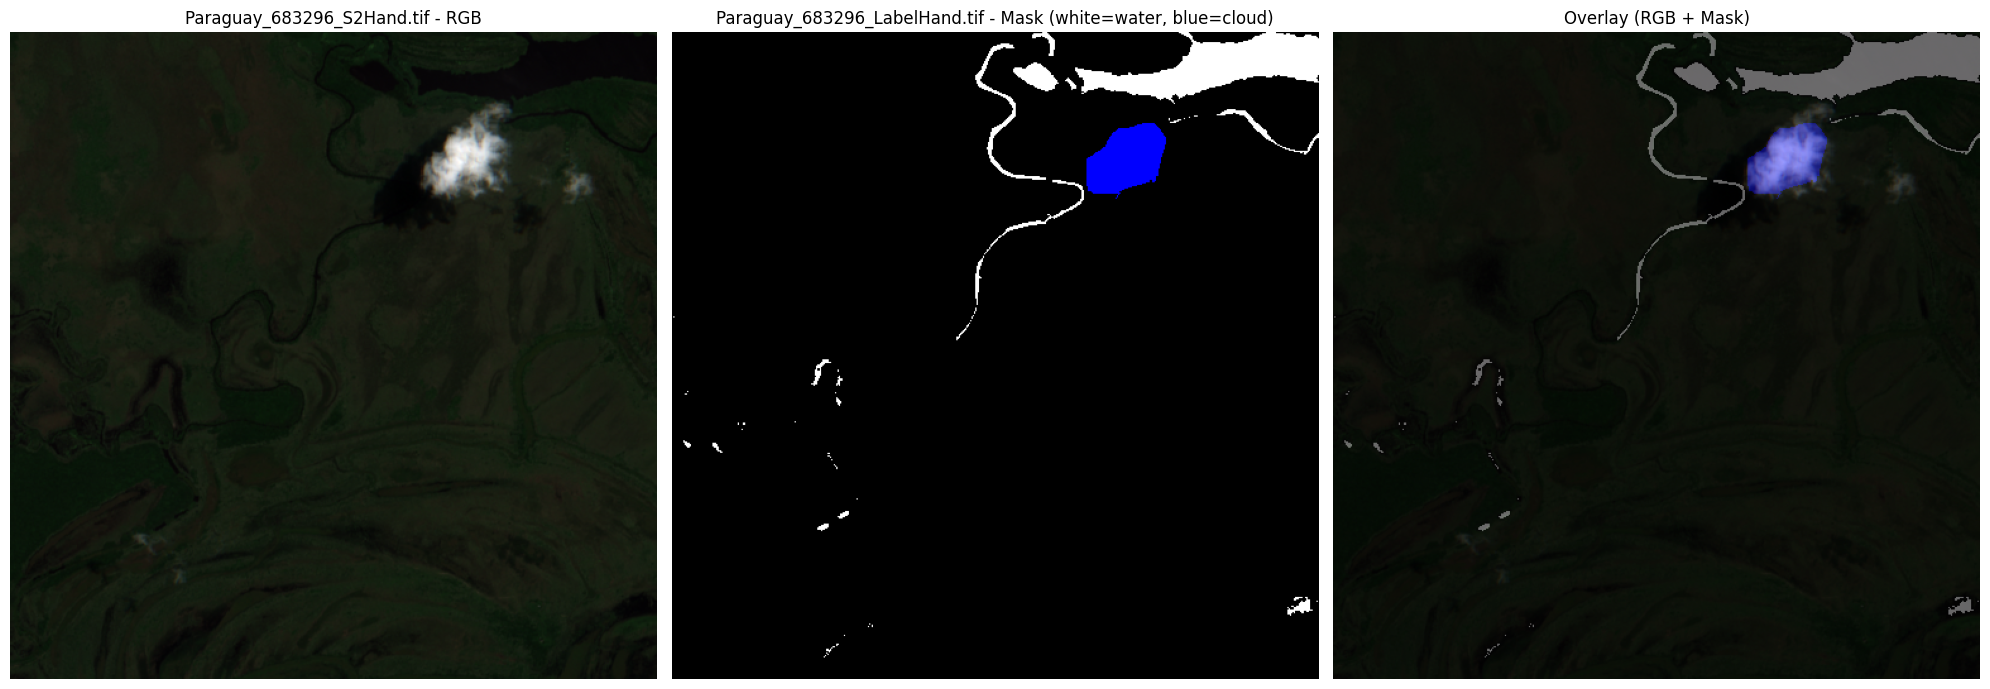

Unique values in original mask: [  0   1 255]


In [9]:
import os
import random
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt

# --- Paths ---
s2_folder = "C:/surfacewatermapping/Sen1Floods11/S2Hand/"
mask_folder = "C:/surfacewatermapping/Sen1Floods11/LabelHand/"

# --- File lists ---
s2_files = sorted([f for f in os.listdir(s2_folder) if f.endswith(".tif")])
mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith(".tif")])

# --- Match mask files to scene IDs ---
mask_dict = {f.split("_")[1]: f for f in mask_files}

# --- Pick a random Sentinel-2 file ---
s2_file = random.choice(s2_files)
scene_id = s2_file.split("_")[1]
mask_file = mask_dict.get(scene_id)

if mask_file is None:
    raise ValueError(f"No mask found for {s2_file}")

s2_path = os.path.join(s2_folder, s2_file)
mask_path = os.path.join(mask_folder, mask_file)

# --- Load Sentinel-2 image ---
with rasterio.open(s2_path) as src:
    img = src.read().astype(np.float32)  # shape: (bands, height, width)
    profile = src.profile
    transform = src.transform
    crs = src.crs

# --- Load and reproject mask ---
with rasterio.open(mask_path) as src:
    mask = src.read(1).astype(np.uint8)
    mask_reproj = np.zeros((profile["height"], profile["width"]), dtype=np.uint8)

    reproject(
        source=mask,
        destination=mask_reproj,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs=crs,
        resampling=Resampling.nearest
    )

# --- Normalize Sentinel-2 bands for visualization ---
img_norm = np.zeros_like(img)
for b in range(img.shape[0]):
    band = img[b]
    img_norm[b] = (band - band.min()) / (band.max() - band.min() + 1e-8)

# --- RGB composite: bands 4 (R), 3 (G), 2 (B) ---
rgb = np.stack([img_norm[3], img_norm[2], img_norm[1]], axis=-1)

# --- Mask visualization (water=white, cloud=blue) ---
mask_display = np.zeros((mask_reproj.shape[0], mask_reproj.shape[1], 3), dtype=np.float32)

# background = black
mask_display[mask_reproj == 0] = [0, 0, 0]
# water = white
mask_display[mask_reproj == 1] = [1, 1, 1]
# cloud = blue
mask_display[mask_reproj == 255] = [0, 0, 1]

# --- Plot: RGB, Mask, Overlay ---
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# RGB
axs[0].imshow(rgb)
axs[0].set_title(f"{s2_file} - RGB")
axs[0].axis("off")

# Mask (water = white, cloud = blue)
axs[1].imshow(mask_display)
axs[1].set_title(f"{mask_file} - Mask (white=water, blue=cloud)")
axs[1].axis("off")

# Overlay (RGB + semi-transparent mask)
axs[2].imshow(rgb)
axs[2].imshow(mask_display, alpha=0.4)
axs[2].set_title("Overlay (RGB + Mask)")
axs[2].axis("off")

plt.tight_layout()
plt.show()

# --- Print unique values in the *original* mask (before reproject & coloring) ---
print("Unique values in original mask:", np.unique(mask))


In [10]:
# --- Paths to save ---
save_folder = "C:/surfacewatermapping/Sen1Floods11/numpy_patches/"
os.makedirs(save_folder, exist_ok=True)

# --- File paths ---
images_path = os.path.join(save_folder, "s2_patches.npy")
masks_path = os.path.join(save_folder, "mask_patches.npy")

# --- Save arrays ---
np.save(images_path, all_patches)
np.save(masks_path, all_mask_patches)

print(f"Sentinel-2 patches saved: {images_path}, shape: {all_patches.shape}")
print(f"Mask patches saved: {masks_path}, shape: {all_mask_patches.shape}")

Sentinel-2 patches saved: C:/surfacewatermapping/Sen1Floods11/numpy_patches/s2_patches.npy, shape: (7136, 128, 128, 13)
Mask patches saved: C:/surfacewatermapping/Sen1Floods11/numpy_patches/mask_patches.npy, shape: (7136, 128, 128, 1)
